## 谢政航捉鬼策略逻辑：
【参数尚未优化】观测到成交量异常大（比过去6小时内平均成交量大2-3倍以上），且价格异常波动（60分钟波动超过1%），则判断有人在大量出货或者入货，是拉涨或拉跌信号，进行跟买，挣足1.5%走人，若亏损千五，则判断此次信号失败并止损。同时在信号来临前增加一个波动率判断仓位操作。因此信号出现，若价格暴跌则卖空，若暴涨则买多。

出场条件：0.5%止损，1.5%止盈

【可优化参数：判断成交量的时间窗口、有效信号的倍数，止损止盈】




In [9]:
from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'ChannelCMT'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    
    # 策略参数
    fastWindow = 5     # 快速均线参数
    slowWindow = 20     # 慢速均线参数
    initDays = 1       # 初始化数据所用的天数
    stopRatio = 0.005   # 止损比例
    
    # 策略变量
    transactionPrice = EMPTY_FLOAT
    
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'fastWindow',
                 'slowWindow',
                'stopRatio']    
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
              'transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(MultiFrameMaStrategy, self).__init__(ctaEngine, setting)
        
        # 生成仓位记录的字典
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        
        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }
             
        # 生成Bar数组
        self.am60Dict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
      

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        # 初始化仓位字典
        if not self.posDict:
            for symbolPos in [self.Longpos,self.Shortpos]:
                self.posDict[symbolPos] = 0

        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll()
        symbol = bar.vtSymbol
        # 基于60分钟判断趋势过滤，因此先更新
        bg60 = self.bg60Dict[symbol]
        bg60.updateBar(bar)
        

        if (self.posDict[self.Longpos] > 0):
            if (bar.close<self.transactionPrice*(1-self.stopRatio)):
                self.cancelAll()
                self.sell(symbol,bar.close, 1)
                #print('止损平多仓，时间：%s,理论止损价格%s'%(bar.datetime,bar.close))
            elif (bar.close>self.transactionPrice*(1+3*self.stopRatio)):
                self.cancelAll()
                self.sell(symbol,bar.close, 1)
                #print('止盈平多仓，时间：%s,理论止盈价格%s'%(bar.datetime,bar.close))
        elif (self.posDict[self.Shortpos] > 0):
            if (bar.close>self.transactionPrice*(1+self.stopRatio)): 
                self.cancelAll()
                self.cover(symbol,bar.close, 1)
                #print('止损平空仓，时间：%s,理论止损价格%s'%(bar.datetime,bar.close))
            elif  (bar.close<self.transactionPrice*(1-3*self.stopRatio)):
                self.cancelAll()
                self.cover(symbol,bar.close, 1)
                #print('止盈平空仓，时间：%s,理论止损价格%s'%(bar.datetime,bar.close)) 
    
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """60分钟K线推送"""
        symbol = bar.vtSymbol
        am60 = self.am60Dict[symbol]
        am60.updateBar(bar)
        
        if not am60.inited:
            return
        
        self.ATR = ta.ATR(am60.high,am60.low,am60.close,8)
        if self.ATR[-1] < 30 :
            self.storage = 5
        elif self.ATR[-1] < 80:
            self.storage = 4
        elif self.ATR[-1] < 180 :
            self.storage = 3
        elif self.ATR[-1] < 500 :
            self.storage = 1
        elif self.ATR[-1] >= 500 :
            self.storage = 0
        self.putEvent()
      
            
        self.Vmax = ta.MAX(am60.volume,timeperiod = 24)
        self.sAve = sum(am60.volume[-11:-1])/10
        
        if am60.volume[-1] > 2.5* self.Vmax[-2] and am60.close[-1]<0.99*am60.close[-2]:
            cross = -1
        elif am60.volume[-1] > 2.5* self.Vmax[-2] and am60.close[-1]>1.01*am60.close[-2]:
            cross = 1
        else:
            cross = 0
#         print(bar.datetime,':',am60.volume[-1],"------------",self.Vmax[-2],'------------',cross)
        
        if cross == 1:

            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.buy(symbol,bar.close*10, self.storage)
                #print('-----buy-----',symbol,bar.close)

            elif (self.posDict[self.Shortpos]!=0):
                self.cover(symbol,bar.close*10, self.posDict[self.Shortpos])
                self.buy(symbol,bar.close*10, self.storage)
                #print('-----cover-----',symbol,bar.close)

        elif cross == -1:

            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.short(symbol,bar.close*0.1, self.storage)
                #print('-----short-----',symbol,bar.close)

            elif  (self.posDict[self.Longpos]!=0): 
                self.sell(symbol,bar.close*0.1,self.storage)
                self.short(symbol,bar.close*0.1, self.posDict[self.Longpos])
                #print('-----sell-----',symbol,bar.close)
        elif cross == 0:
            pass
                
        # 发出状态更新事件
        self.putEvent()


    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        #print("------收到成交推送-------")
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(self.posDict)
        #print("------收到Trade推送-------")
        self.transactionPrice = trade.price
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        #print("------收到停止单推送-------")
        pass

## 配置引擎回测

In [10]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20180101',initDays=1)          # 设置回测用的数据起始日期
    engine.setEndDate('20180826')
    # 配置回测引擎参数
    engine.setSlippage(0.2)     # 设置滑点为股指1跳
    engine.setRate(1/1000)   # 设置手续费万0.3
    engine.setSize(1)         # 设置股指合约大小
    # engine.setPriceTick(0.0001)    # 设置股指最小价格变动
    engine.setCapital(10000)  # 设置回测本金

    # # 在引擎中创建策略对象
    d = {'symbolList':['tBTCUSD:bitfinex']}          # 策略参数配置
    engine.initStrategy(MultiFrameMaStrategy, d)    # 创建策略对象
    engine.runBacktesting()

2018-09-06 17:37:30.396459	开始回测
2018-09-06 17:37:30.396459	策略初始化
2018-09-06 17:37:30.396459	载入历史数据。数据范围:[20171231,20180101)
2018-09-06 17:37:30.640473	载入完成，数据量：1414
2018-09-06 17:37:30.657474	策略初始化完成
2018-09-06 17:37:30.657474	策略启动完成
2018-09-06 17:37:30.657474	开始回放回测数据,回测范围:[20180101,20180827)
2018-09-06 17:37:30.659474	载入历史数据。数据范围:[20180101,20180827)
2018-09-06 17:38:14.504982	载入完成，数据量：381185
2018-09-06 17:38:14.504982	当前回放数据:[20180101,20180827)
2018-09-06 17:38:18.465208	数据回放结束ss: 100%    


In [11]:
for i in range(100):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

TradeID: 1, Time: 2018-01-03 03:01:00, Direction: 多, Price: 14605.0, Volume: 1
TradeID: 2, Time: 2018-01-03 03:12:00, Direction: 空, Price: 14842.0, Volume: 1
TradeID: 3, Time: 2018-01-26 17:01:00, Direction: 空, Price: 10714.0, Volume: 1
TradeID: 4, Time: 2018-01-26 17:21:00, Direction: 多, Price: 10551.0, Volume: 1
TradeID: 5, Time: 2018-02-05 05:01:00, Direction: 空, Price: 8080.2, Volume: 1
TradeID: 6, Time: 2018-02-05 05:12:00, Direction: 多, Price: 8200.0, Volume: 1
TradeID: 7, Time: 2018-02-14 21:01:00, Direction: 多, Price: 9140.0, Volume: 3
TradeID: 8, Time: 2018-02-14 21:19:00, Direction: 空, Price: 9285.0, Volume: 1
TradeID: 9, Time: 2018-02-14 21:30:00, Direction: 空, Price: 9226.0, Volume: 1
TradeID: 10, Time: 2018-02-14 22:13:00, Direction: 空, Price: 9175.0, Volume: 1
TradeID: 11, Time: 2018-02-26 22:01:00, Direction: 多, Price: 10160.0, Volume: 1
TradeID: 12, Time: 2018-02-26 22:15:00, Direction: 空, Price: 10351.0, Volume: 1
TradeID: 13, Time: 2018-03-08 01:01:00, Direction: 空, P

2018-09-06 17:38:18.504210	计算按日统计结果
2018-09-06 17:38:18.576214	------------------------------
2018-09-06 17:38:18.579215	首个交易日：	2018-01-01
2018-09-06 17:38:18.580215	最后交易日：	2018-08-26
2018-09-06 17:38:18.580215	总交易日：	238
2018-09-06 17:38:18.580215	盈利交易日	26
2018-09-06 17:38:18.580215	亏损交易日：	11
2018-09-06 17:38:18.580215	起始资金：	10000
2018-09-06 17:38:18.580215	结束资金：	15,741.94
2018-09-06 17:38:18.580215	总收益率：	57.42%
2018-09-06 17:38:18.580215	年化收益：	57.9%
2018-09-06 17:38:18.580215	总盈亏：	5,741.94
2018-09-06 17:38:18.581215	最大回撤: 	-781.38
2018-09-06 17:38:18.581215	百分比最大回撤: -5.37%
2018-09-06 17:38:18.581215	总手续费：	1,282.52
2018-09-06 17:38:18.581215	总滑点：	34.8
2018-09-06 17:38:18.581215	总成交金额：	1,282,519.55
2018-09-06 17:38:18.581215	总成交笔数：	115
2018-09-06 17:38:18.581215	日均盈亏：	24.13
2018-09-06 17:38:18.581215	日均手续费：	5.39
2018-09-06 17:38:18.581215	日均滑点：	0.15
2018-09-06 17:38:18.581215	日均成交金额：	5,388.74
2018-09-06 17:38:18.581215	日均成交笔数：	0.48
2018-09-06 17:38:18.581215	日均收益率：	0.19%
2018-09-06 17:3

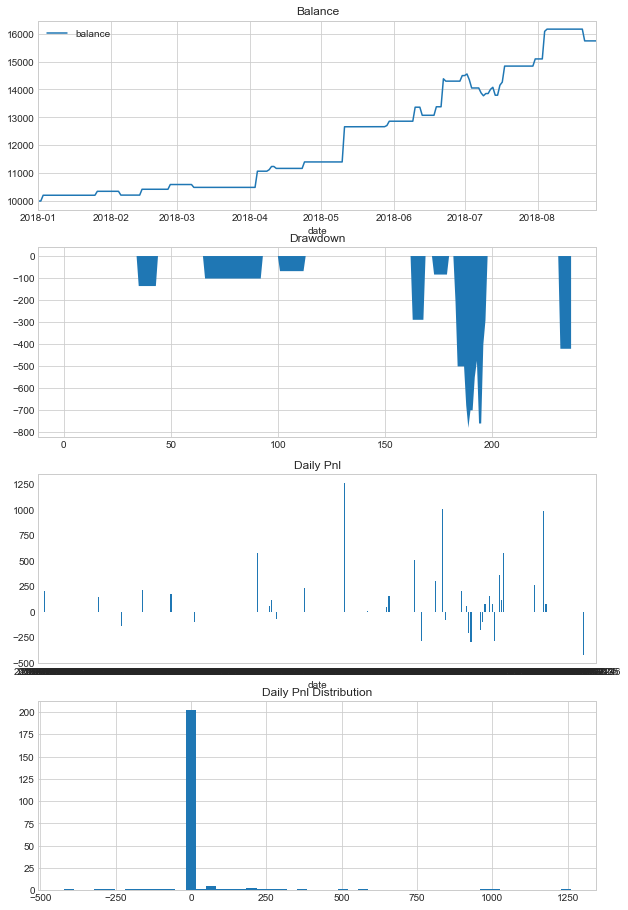

2018-09-06 17:38:20.885346	计算回测结果
2018-09-06 17:38:20.892347	------------------------------
2018-09-06 17:38:20.892347	第一笔交易：	2018-01-03 03:12:00
2018-09-06 17:38:20.892347	最后一笔交易：	2018-08-21 15:15:00
2018-09-06 17:38:20.892347	总交易次数：	87
2018-09-06 17:38:20.892347	总盈亏：	5,741.94
2018-09-06 17:38:20.892347	最大回撤: 	-704.11
2018-09-06 17:38:20.892347	平均每笔盈利：	66.0
2018-09-06 17:38:20.892347	平均每笔滑点：	0.4
2018-09-06 17:38:20.892347	平均每笔佣金：	14.74
2018-09-06 17:38:20.892347	胜率		71.26%
2018-09-06 17:38:20.892347	盈利交易平均值	125.63
2018-09-06 17:38:20.892347	亏损交易平均值	-81.9
2018-09-06 17:38:20.892347	盈亏比：	1.53


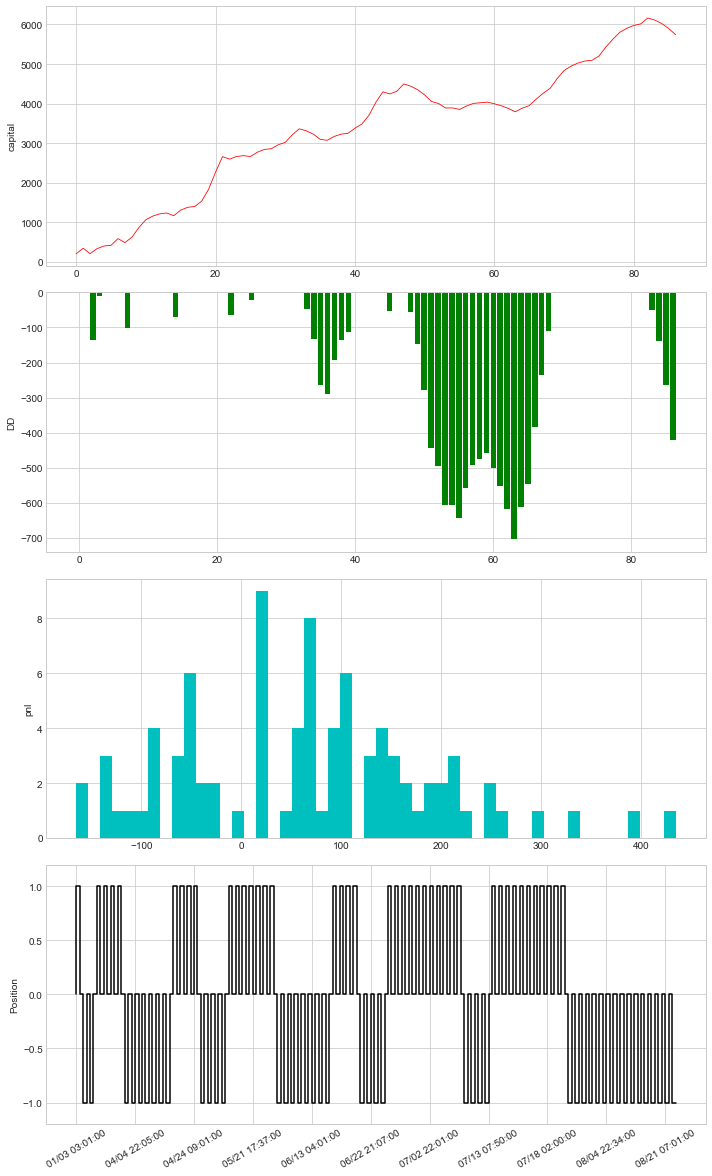

In [12]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

2018-09-06 17:36:15.548178	计算按日统计结果
2018-09-06 17:36:16.009204	------------------------------
2018-09-06 17:36:16.009204	首个交易日：	2017-07-02
2018-09-06 17:36:16.009204	最后交易日：	2018-08-26
2018-09-06 17:36:16.009204	总交易日：	421
2018-09-06 17:36:16.009204	盈利交易日	36
2018-09-06 17:36:16.009204	亏损交易日：	24
2018-09-06 17:36:16.009204	起始资金：	10000
2018-09-06 17:36:16.025205	结束资金：	15,438.69
2018-09-06 17:36:16.025205	总收益率：	54.39%
2018-09-06 17:36:16.025205	年化收益：	31.0%
2018-09-06 17:36:16.025205	总盈亏：	5,438.69
2018-09-06 17:36:16.025205	最大回撤: 	-781.38
2018-09-06 17:36:16.025205	百分比最大回撤: -5.88%
2018-09-06 17:36:16.026205	总手续费：	1,863.27
2018-09-06 17:36:16.026205	总滑点：	61.6
2018-09-06 17:36:16.026205	总成交金额：	1,863,265.05
2018-09-06 17:36:16.026205	总成交笔数：	200
2018-09-06 17:36:16.026205	日均盈亏：	12.92
2018-09-06 17:36:16.026205	日均手续费：	4.43
2018-09-06 17:36:16.026205	日均滑点：	0.15
2018-09-06 17:36:16.026205	日均成交金额：	4,425.81
2018-09-06 17:36:16.026205	日均成交笔数：	0.48
2018-09-06 17:36:16.026205	日均收益率：	0.1%
2018-09-06 17:36

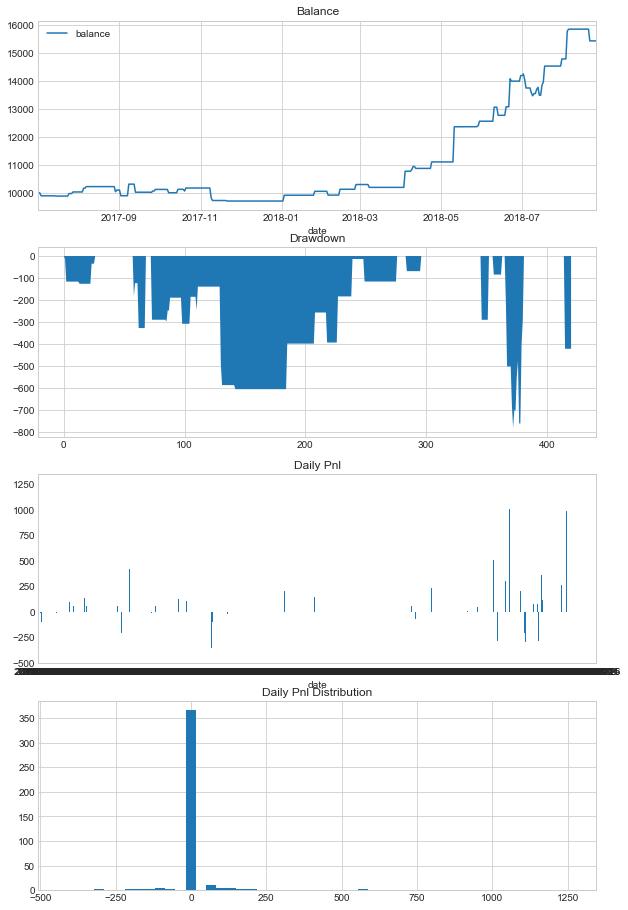

2018-09-06 17:36:21.183500	计算回测结果
2018-09-06 17:36:21.197501	------------------------------
2018-09-06 17:36:21.197501	第一笔交易：	2017-07-03 22:37:00
2018-09-06 17:36:21.198501	最后一笔交易：	2018-08-21 15:15:00
2018-09-06 17:36:21.198501	总交易次数：	154
2018-09-06 17:36:21.198501	总盈亏：	5,438.69
2018-09-06 17:36:21.198501	最大回撤: 	-704.11
2018-09-06 17:36:21.198501	平均每笔盈利：	35.32
2018-09-06 17:36:21.198501	平均每笔滑点：	0.4
2018-09-06 17:36:21.198501	平均每笔佣金：	12.1
2018-09-06 17:36:21.198501	胜率		62.34%
2018-09-06 17:36:21.198501	盈利交易平均值	95.48
2018-09-06 17:36:21.198501	亏损交易平均值	-64.27
2018-09-06 17:36:21.198501	盈亏比：	1.49


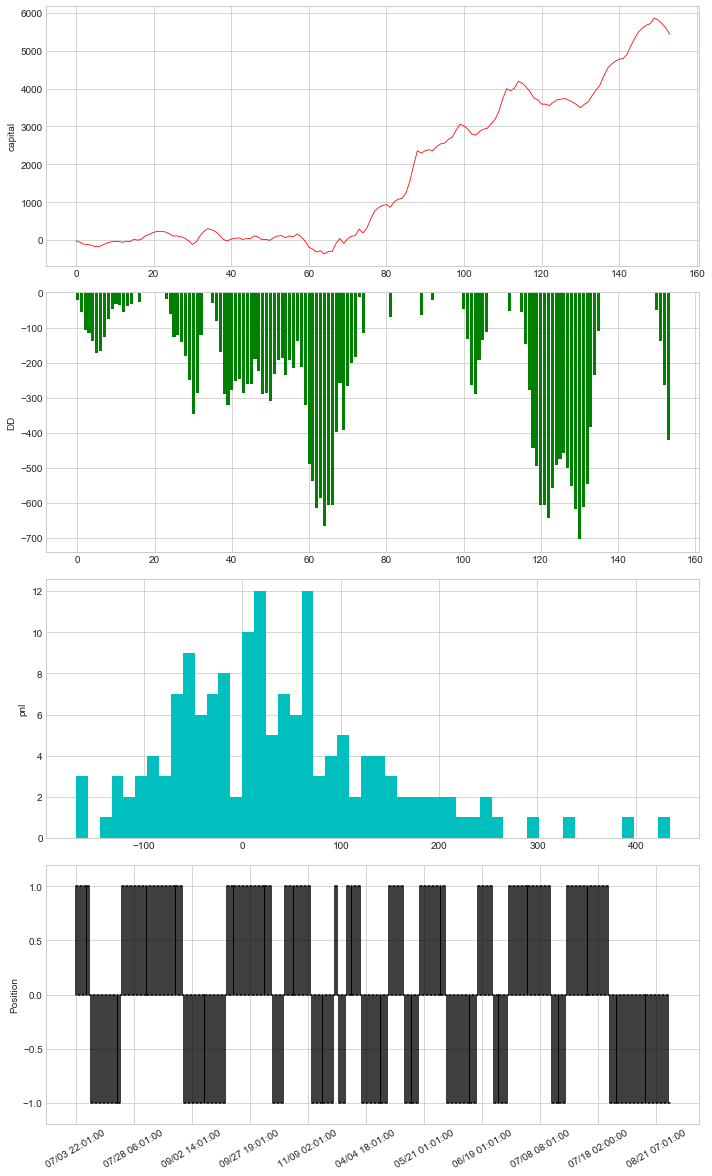

In [8]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

2018-08-30 11:22:08.975403	计算按日统计结果
2018-08-30 11:22:09.104410	------------------------------
2018-08-30 11:22:09.107410	首个交易日：	2017-07-20
2018-08-30 11:22:09.109410	最后交易日：	2018-08-26
2018-08-30 11:22:09.111410	总交易日：	403
2018-08-30 11:22:09.111410	盈利交易日	36
2018-08-30 11:22:09.112410	亏损交易日：	21
2018-08-30 11:22:09.112410	起始资金：	10000
2018-08-30 11:22:09.112410	结束资金：	15,564.82
2018-08-30 11:22:09.112410	总收益率：	55.65%
2018-08-30 11:22:09.112410	年化收益：	33.14%
2018-08-30 11:22:09.112410	总盈亏：	5,564.82
2018-08-30 11:22:09.112410	最大回撤: 	-781.38
2018-08-30 11:22:09.112410	百分比最大回撤: -5.8%
2018-08-30 11:22:09.112410	总手续费：	1,825.43
2018-08-30 11:22:09.112410	总滑点：	58.4
2018-08-30 11:22:09.112410	总成交金额：	1,825,434.35
2018-08-30 11:22:09.112410	总成交笔数：	190
2018-08-30 11:22:09.112410	日均盈亏：	13.81
2018-08-30 11:22:09.112410	日均手续费：	4.53
2018-08-30 11:22:09.112410	日均滑点：	0.14
2018-08-30 11:22:09.112410	日均成交金额：	4,529.61
2018-08-30 11:22:09.112410	日均成交笔数：	0.47
2018-08-30 11:22:09.112410	日均收益率：	0.11%
2018-08-30 11:2

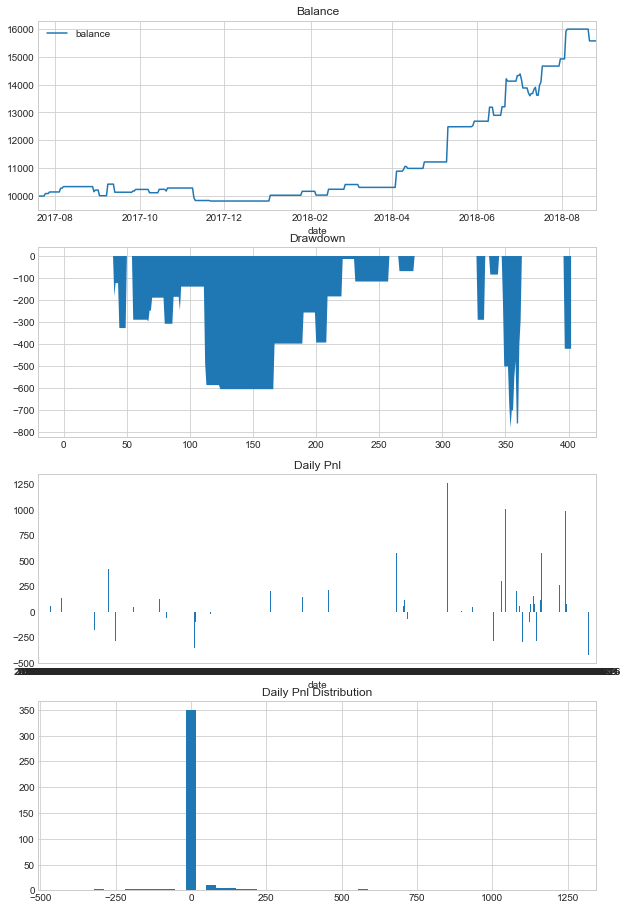

2018-08-30 11:22:13.910685	计算回测结果
2018-08-30 11:22:13.922686	------------------------------
2018-08-30 11:22:13.923686	第一笔交易：	2017-07-25 15:30:00
2018-08-30 11:22:13.923686	最后一笔交易：	2018-08-21 15:15:00
2018-08-30 11:22:13.923686	总交易次数：	146
2018-08-30 11:22:13.923686	总盈亏：	5,564.82
2018-08-30 11:22:13.923686	最大回撤: 	-704.11
2018-08-30 11:22:13.923686	平均每笔盈利：	38.12
2018-08-30 11:22:13.923686	平均每笔滑点：	0.4
2018-08-30 11:22:13.923686	平均每笔佣金：	12.5
2018-08-30 11:22:13.923686	胜率		64.38%
2018-08-30 11:22:13.923686	盈利交易平均值	97.03
2018-08-30 11:22:13.923686	亏损交易平均值	-68.38
2018-08-30 11:22:13.923686	盈亏比：	1.42


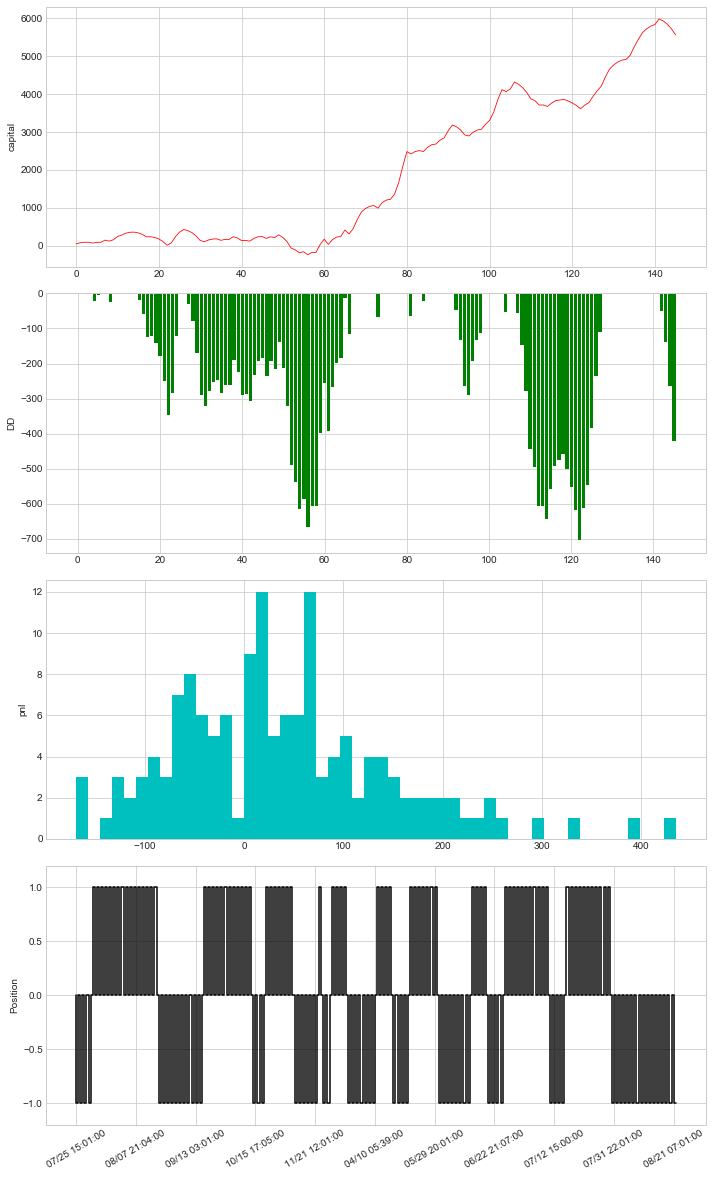

In [133]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()


2018-08-30 10:19:19.096778	计算按日统计结果
2018-08-30 10:19:19.115779	------------------------------
2018-08-30 10:19:19.115779	首个交易日：	2018-07-20
2018-08-30 10:19:19.115779	最后交易日：	2018-08-26
2018-08-30 10:19:19.115779	总交易日：	38
2018-08-30 10:19:19.115779	盈利交易日	25
2018-08-30 10:19:19.115779	亏损交易日：	12
2018-08-30 10:19:19.115779	起始资金：	10000
2018-08-30 10:19:19.115779	结束资金：	11,600.81
2018-08-30 10:19:19.115779	总收益率：	16.01%
2018-08-30 10:19:19.115779	年化收益：	101.1%
2018-08-30 10:19:19.115779	总盈亏：	1,600.81
2018-08-30 10:19:19.116779	最大回撤: 	-632.86
2018-08-30 10:19:19.116779	百分比最大回撤: -6.14%
2018-08-30 10:19:19.116779	总手续费：	484.16
2018-08-30 10:19:19.116779	总滑点：	13.4
2018-08-30 10:19:19.116779	总成交金额：	484,155.47
2018-08-30 10:19:19.116779	总成交笔数：	67
2018-08-30 10:19:19.116779	日均盈亏：	42.13
2018-08-30 10:19:19.116779	日均手续费：	12.74
2018-08-30 10:19:19.116779	日均滑点：	0.35
2018-08-30 10:19:19.116779	日均成交金额：	12,740.93
2018-08-30 10:19:19.116779	日均成交笔数：	1.76
2018-08-30 10:19:19.116779	日均收益率：	0.37%
2018-08-30 10:19:1

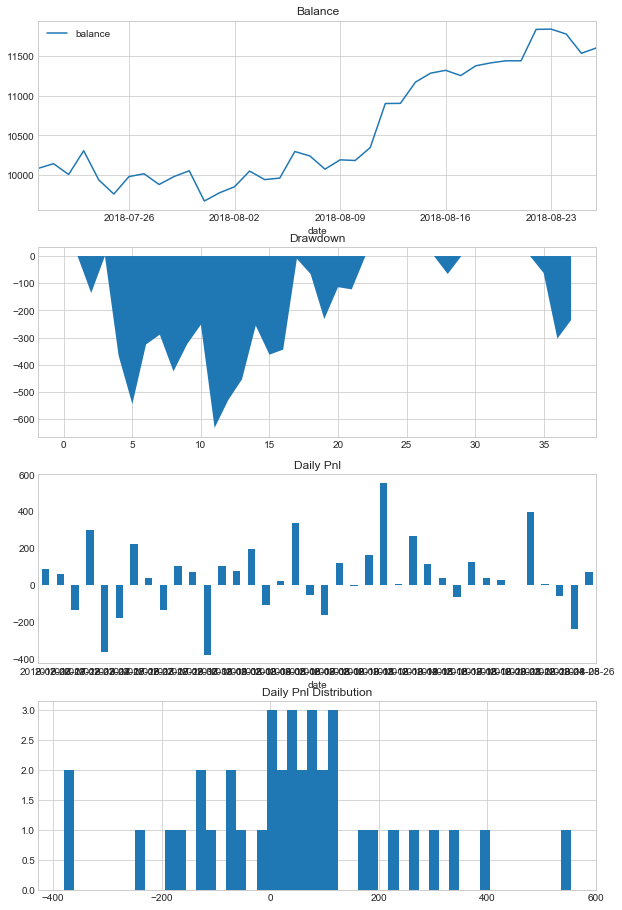

2018-08-30 10:19:20.171839	计算回测结果
2018-08-30 10:19:20.175840	------------------------------
2018-08-30 10:19:20.175840	第一笔交易：	2018-07-21 01:00:00
2018-08-30 10:19:20.175840	最后一笔交易：	2018-08-26 23:59:00
2018-08-30 10:19:20.175840	总交易次数：	34
2018-08-30 10:19:20.175840	总盈亏：	1,593.93
2018-08-30 10:19:20.175840	最大回撤: 	-754.67
2018-08-30 10:19:20.175840	平均每笔盈利：	46.88
2018-08-30 10:19:20.175840	平均每笔滑点：	0.4
2018-08-30 10:19:20.175840	平均每笔佣金：	14.44
2018-08-30 10:19:20.175840	胜率		67.65%
2018-08-30 10:19:20.175840	盈利交易平均值	153.01
2018-08-30 10:19:20.175840	亏损交易平均值	-175.03
2018-08-30 10:19:20.175840	盈亏比：	0.87


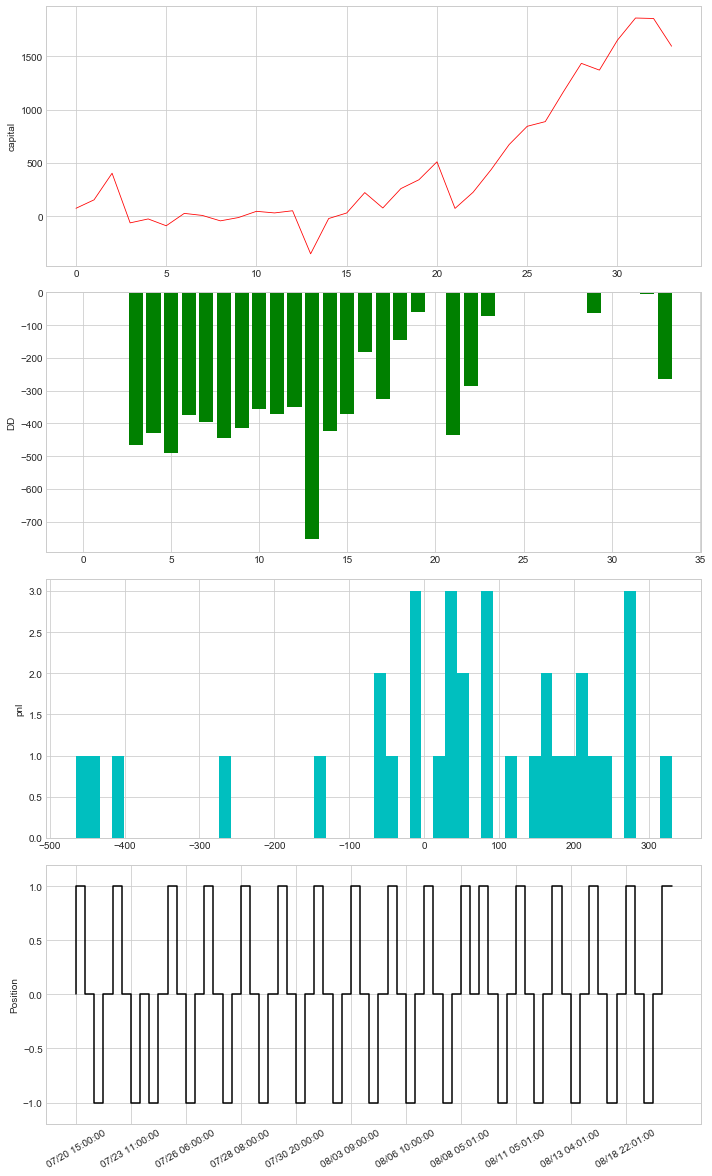

In [39]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()
'''观测到成交量异常大（比过去6小时内平均成交量大2-3倍以上），且价格异常波动（60分钟波动超过1%），则判断有人在大量出货或者入货，接下来价格可能反弹。因此信号出现，若价格暴跌则买多，若暴涨则卖空。'''

In [ ]:
import pandas as pd
TradeDf = pd.DataFrame([engine.tradeDict[str(i+1)].__dict__ for i in range(10)])
multiFrameMaTrade = TradeDf.set_index('dt')

In [ ]:
print(multiFrameMaTrade.tail())

In [ ]:
# multiFrameMaTrade.to_excel('tradeMultiFrameMa.xlsx')

In [ ]:
for i in range(100):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

## 查看绩效与优化

In [ ]:
PerfromanceDf = engine.calculateDailyResult()

In [ ]:
PerfromanceDf.to_excel('perfromanceMultiFrameMa.xlsx')

In [ ]:
df1, result = engine.calculateDailyStatistics(PerfromanceDf)

In [ ]:
result

In [ ]:
# 优化配置
setting = OptimizationSetting()                 # 新建一个优化任务设置对象
setting.setOptimizeTarget('totalNetPnl')        # 设置优化排序的目标是策略净盈利
setting.addParameter('fastWindow', 2, 15, 3)    # 增加第一个优化参数atrLength，起始12，结束20，步进2
#setting.addParameter('slowWindow', 70, 90, 10)        # 增加第二个优化参数atrMa，起始20，结束30，步进5
setting.addParameter('symbolList', ['tBTCUSD:bitfinex']) 
#setting.addParameter('rsiLength', 5)            # 增加一个固定数值的参数

# 执行多进程优化
import time
start = time.time()
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

In [ ]:
resultList

In [ ]:
import pandas as pd

print(pd.DataFrame(resultList).sort_values(1,  ascending=False).iloc[0:5])

In [ ]:
# 显示优化的所有统计数据
for result in resultList:
    print('-' * 30)
    print('参数：%s，目标：%s' %(result[0], result[1]))
    print('统计数据：')
    for k, v in result[2].items():
        print('%s：%s' %(k, v))